# Report
The data set is "pertussis 51.12.csv" which containes 49 states of USA data during 1951 January to 2012 December. (1 per month = 744 samples)

In [172]:
import pandas as pd
data_df = pd.read_csv('pertussis.51.12.csv')

In [179]:
data_df.head(3)

,YEAR,MONTH,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District.of.Columbia,...,South.Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West.Virginia,Wisconsin,Wyoming
0,1951,1,132.0,251.0,124.0,256.0,117.0,105.0,19.0,23.0,...,6.0,89.0,886.0,6.0,250.0,330.0,116.0,152.0,335.0,12.0
1,1951,2,94.0,206.0,217.0,199.0,52.0,66.0,4.0,23.0,...,20.0,33.0,1177.0,10.0,108.0,197.0,52.0,155.0,277.0,12.0
2,1951,3,102.0,352.0,142.0,185.0,71.0,19.0,6.0,16.0,...,6.0,86.0,1583.0,38.0,39.0,279.0,76.0,193.0,190.0,27.0


Now we want to create the time variable (%Y-%m-%d) based on the first and second columns (YEAR, MONTH)


In [177]:
Dates = data_df [ ["YEAR","MONTH"] ]
time = Dates['YEAR'].astype(str) + "-" + Dates['MONTH'].astype(str) + "-01" #For each state ?
time = pd.to_datetime(time , format = '%Y-%m-%d')

Also we need time series based on the float(64) to plot the data easily. (1951.1, 1957,2, 1951,3 ... 1951.12, 1953.0, 1953.1, 1953.2, ...)

In [163]:
Y = data_df["YEAR"]
M = data_df["MONTH"]
New_M = M / 12.0   # one way
Time_Series = Y.values + New_M.values

In california_EWS.py you will see that we can get ghe name of the state and doing the moving average.

In [164]:
state_name = "California"

Given The name of the state we can do the moving average.

In [178]:
import statsmodels.api as sm

state = ( data_df[state_name] )

state.index = pd.DatetimeIndex(time[:len(state)])

# for filling with average! ---------------------  # can be better later ...
data_df_np_array = data_df[state_name].values 
average = np.nanmean(data_df_np_array)
#------------------------------------------------
res = sm.tsa.seasonal_decompose ( (data_df[state_name]) .fillna(average) ,freq=12)

pertussis_observed_state = res.observed
pertussis_seasonal_state = res.seasonal
pertussis_trend_state = res.trend

#------------For doing the segmented linear regression we need to create the funciton in a file name piecewise.
it takes x and y as an array.--------------

In [169]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from linear_fit import linear_fit #local function

#============================================ Segmented Linear Regression ==============================================
# this function is using in segmented_linear_regression function.
import numpy as np
def linear_fit( x , a1, b1, a2, b2, bp ):
    x = x.reshape(-1)
    def lf(xi):
        if(xi < x[bp]):
            return(a1*xi + b1)
        else:
            return(a2*xi + b2)

    return(np.array([lf(i) for i in x]))

#=======================================================================================================================
def piecewise(x,y):
    x = x.reshape(-1,1)
    y= y.reshape(-1,1)

    print("Len of X array is:",len(x))
    print("Len of Y array is:",len(y))

    model1 = LinearRegression()  # fit_intercept = False
    model2 = LinearRegression()  # fit_intercept = False
    s = -np.inf
    for i in range(1,len(x)):

        model1.fit(x[:i], y[:i])
        model2.fit(x[i:], y[i:])

        s1 = model1.score(x[:i],y[:i])
        s2 = model2.score(x[i:],y[i:])
        if(s1+s2 > s):
            s = s1+s2
            a1 = model1.coef_.reshape(-1)
            a2 = model2.coef_.reshape(-1)
            b1 = model1.intercept_
            b2 = model2.intercept_
            bp = i

    y_fit = linear_fit(x, a1, b1, a2, b2, bp)

    #print(y_fit)
    #print(y_fit[x < x[bp]])
    plt.figure(figsize=(16, 12))
    plt.plot(x.reshape(-1),y.reshape(-1),'b')

    plt.plot(x[x <x[bp]],y_fit[x < x[bp]],'r')
    plt.plot(x[x >=x[bp]],y_fit[x >=x[bp]],'r')

    return y_fit.reshape(-1) # Transfer the Horizantal to Vertical!
    #print(y_fit[bp])

    #plt.show()
#=======================================================================================================================

#simple example:
#input ()
'''
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15])
y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])
piecewise(x,y)
'''

'\nx = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15])\ny = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])\npiecewise(x,y)\n'

#----------------------------------------           So now we can use our variables (pertussis rate, time) as an input to get our final result     ---------------------------------#

#--------------------------------------------------------------------------- Piece wise on Trend --------------------------------------------------------------------------------------#

In [170]:
x = np.array(Time_Series[:len(pertussis_trend_state.dropna())])
y = np.array(pertussis_trend_state.dropna())

In [180]:
piecewise(x, y)
plt.title("California")
#plt.show()

Len of X array is: 732
Len of Y array is: 732


----------------------------------------------------------------------- EWS PLOT PACKAGE !

Len of X array is: 732
Len of Y array is: 732


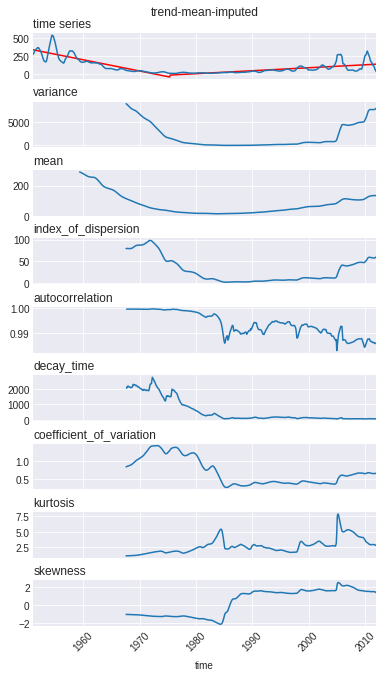

In [131]:
import ews
import ews_plot

piecewise_fited = piecewise(x,y)

filename="Cal_using_mean/"+str(state_name)+"_Trend"+".pdf"

ews_df = ews.get_ews(y, windowsize=100, ac_lag=1)
ews_df["Time"] = x
signals = ["variance","mean","index_of_dispersion","autocorrelation","decay_time","coefficient_of_variation","kurtosis","skewness"]

ews_df["piecewise_fited"] = piecewise_fited #Added Now

ews_plot.ews_plot (ews_df,signals,filename,"trend-mean-imputed")